# Image reconstruction by autoencoder

In [62]:
import os

import tensorflow as tf
import helpers as helpers
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)
!pwd

%cd ..
%ls
!source set_env.sh
%cd scripts

print(os.environ['DATA'])


/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/scripts
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM
#set_env.sh#         logs/                set_env.sh
README.md            models/              supervised_learning/
data/                plots/               test2/
data_maxnorm/        scripts/
setting some environment variables
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/scripts
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/data/good_2016


In [63]:
def my_log_loss(y_true, y_pred, eps=1e-15):
   # y_pred = np.clip(y_pred, eps, 1 - eps)
    loss_matrix=np.sqrt((y_true-y_pred)*(y_true-y_pred))
    #loss_matrix= -(y_true * np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
    #print(loss_matrix.shape)
   # print(loss_matrix)

    return loss_matrix.mean()

def window_loss(y_true,y_pred,window_size=10,step_size=5):
    #print(y_true.shape)
    x_length=y_true.shape[1]
    
    y_length=y_true.shape[0]
    max_loss,max_loss_x,max_loss_y=0,0,0
    #print(max_loss,max_loss_x,max_loss_y)
    for channel_y in range(0,y_length,step_size):
        for channel_x in range(0,x_length,step_size):
            current_window_true=y_true[channel_y:channel_y+window_size,channel_x:channel_x+window_size]
            current_window_pred=y_pred[channel_y:channel_y+window_size,channel_x:channel_x+window_size]
            
            current_loss=my_log_loss(current_window_true,current_window_pred)
            #print(current_window_true,current_window_pred,current_loss)
            #print(current_loss,channel_y,channel_x)
            if current_loss>max_loss:
                max_loss=current_loss
                max_loss_x=channel_x
                max_loss_y=channel_y
    return max_loss,max_loss_x,max_loss_y
            
            
            
         

## Look at a good input image and then its reconstruction
Load a good input image and plot it. These are ECAL Barrel rechit occupancy images.

[[-0.90570682 -0.36197636  0.72548521  0.45361975]
 [ 0.72548521  0.45361975  0.45361975 -1.17757213]
 [ 0.99735039 -0.09011089  0.18175428  0.45361975]
 [-0.09011089 -0.90570682 -1.17757213  0.72548521]]
Shape of image is:  (170, 360)


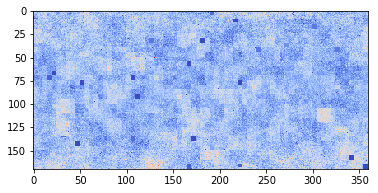

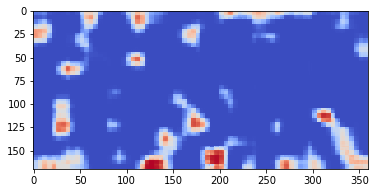

1/1 [==============================] - 8s
['loss']
Recon loss is:  0.89029610157
(3.6230643, 355, 165)
(6.9783878, 130, 50)


In [74]:
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='good_2016')
input_image=data_sample[300,:]
print(input_image[1:5,1:5])
print("Shape of image is: ",input_image.shape)
im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.show()
plt.clf()
input_image_batch=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))


import keras.models as models
model_name='model_v20_MSE_adadelta'
trained_model=models.load_model(os.environ['BASEDIR']+"/models/"+model_name+".h5")
reconstructed_image_batch=trained_model.predict(input_image_batch)
reconstructed_image=np.reshape(reconstructed_image_batch,(input_image_batch.shape[2],input_image_batch.shape[3]))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.show()
plt.imsave("good_image.png",input_image)
z=trained_model.evaluate(input_image_batch,input_image_batch,verbose=1)
print(trained_model.metrics_names)
print("Recon loss is: ",z)
a=window_loss(input_image,reconstructed_image)
print(a)
b=window_loss(input_image,reconstructed_image,window_size=1,step_size=1)
print(b)

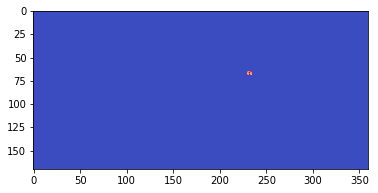

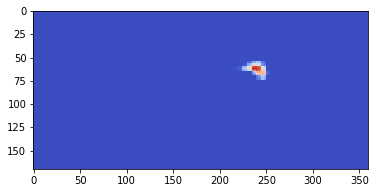

Recon loss is:  1.00098288059
average loss in 10x10 window:  (12.662174, 230, 60)
average loss in 1x1 window:  (59.985096, 232, 68)


In [71]:
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='bad_2016/hot_towers')
pick_image=np.random.choice(np.arange(data_sample.shape[0]))
input_image=data_sample[0,:]
im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.show()
plt.clf()
input_image_batch=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))
reconstructed_image_batch=trained_model.predict(input_image_batch)
reconstructed_image=np.reshape(reconstructed_image_batch,(input_image_batch.shape[2],input_image_batch.shape[3]))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.show()
z=trained_model.evaluate(input_image_batch,input_image_batch,batch_size=41,verbose=0)
print("Recon loss is: ",z)
a=window_loss(input_image,reconstructed_image)
print("average loss in 10x10 window: ",a)
b=window_loss(input_image,reconstructed_image,window_size=1,step_size=1)
print("average loss in 1x1 window: ",b)

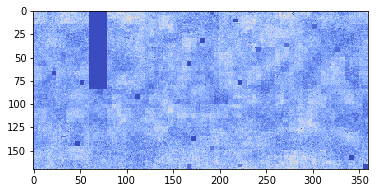

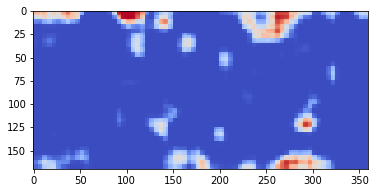

average loss in 10x10 window:  (2.6779833, 70, 0)
average loss in 1x1 window:  (8.1835442, 130, 50)


In [73]:
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='bad_2016/missing_modules')

input_image=data_sample[0,:]

im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.show()
plt.clf()
input_image_batch=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))
reconstructed_image_batch=trained_model.predict(input_image_batch)
reconstructed_image=np.reshape(reconstructed_image_batch,(input_image_batch.shape[2],input_image_batch.shape[3]))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.show()
plt.imsave("missing_module.png",input_image)
a=window_loss(input_image,reconstructed_image)
print("average loss in 10x10 window: ",a)
b=window_loss(input_image,reconstructed_image,window_size=1,step_size=1)
print("average loss in 1x1 window: ",b)